In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=e85c8ade4aa9e7af1c39489707f21fa17254d26535030de33f46291312c4faaf
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, round, expr
from pyspark.ml.feature import VectorAssembler


In [4]:
# Create a SparkSession
spark = SparkSession.builder.appName("BostonHousingEDA").getOrCreate()

# Read the CSV file into a Spark DataFrame
df = spark.read.csv("BostonHousing.csv", header=True)


In [5]:
# Show the first 5 elements
df.show(5)

+-------+---+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim| zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+---+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632| 18| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|  24|
|0.02731|  0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729|  0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237|  0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905|  0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+---+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [6]:
# Count the number of observations
count = df.count()
print(f"Number of observations: {count}")


Number of observations: 506


In [7]:
# Show the schema
df.printSchema()

root
 |-- crim: string (nullable = true)
 |-- zn: string (nullable = true)
 |-- indus: string (nullable = true)
 |-- chas: string (nullable = true)
 |-- nox: string (nullable = true)
 |-- rm: string (nullable = true)
 |-- age: string (nullable = true)
 |-- dis: string (nullable = true)
 |-- rad: string (nullable = true)
 |-- tax: string (nullable = true)
 |-- ptratio: string (nullable = true)
 |-- b: string (nullable = true)
 |-- lstat: string (nullable = true)
 |-- medv: string (nullable = true)



In [8]:
# Drop the column "b" assuming it doesn't exist in the downloaded dataset
# Remove this line if "b" exists
df = df.drop("b")

In [9]:
# Round all numerical columns to two decimal places
from pyspark.sql.types import FloatType
for col_name in df.schema.names:
  if df.schema[col_name].dataType == FloatType():
    df = df.withColumn(col_name, round(col(col_name), 2))

In [10]:
# Create a new column (Age10) with a 10% increase of 'age' column (assuming 'age' exists)
# Modify the column name if 'age' doesn't exist
df = df.withColumn("Age10", expr("age * 1.1"))


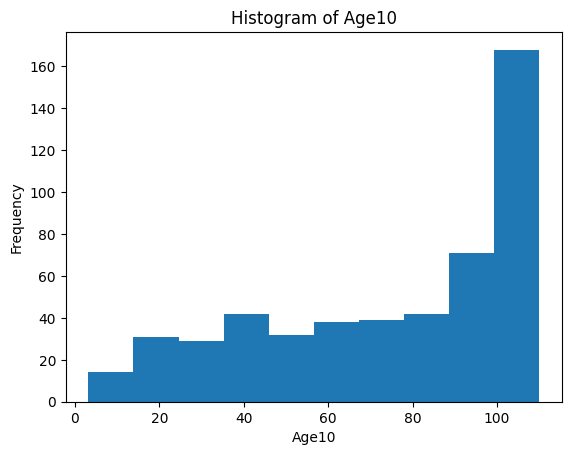

In [18]:
# Plot histogram for Age10 column (using matplotlib)
import matplotlib.pyplot as plt
pdf = df.toPandas()
%matplotlib inline
plt.hist(pdf["Age10"])
plt.xlabel("Age10")
plt.ylabel("Frequency")
plt.title("Histogram of Age10")
plt.show()



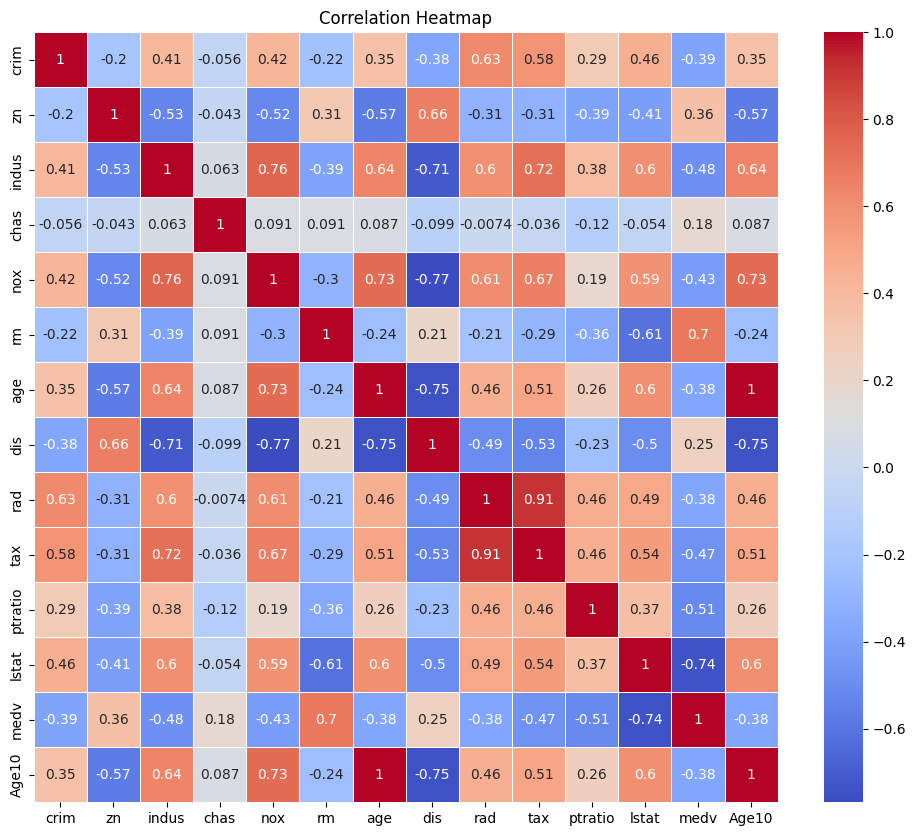

In [20]:
#Correlation Heatmap
import matplotlib.pyplot as plt
import seaborn as sns # Import the seaborn module

plt.figure(figsize=(12, 10))
corr_matrix = pdf.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

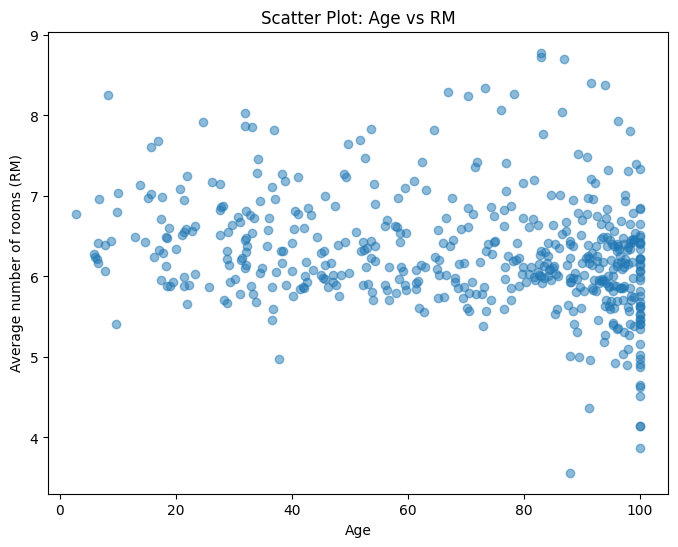

In [21]:
# Scatter Plot between 'age' and 'rm'
plt.figure(figsize=(8, 6))
plt.scatter(pdf['age'], pdf['rm'], alpha=0.5)
plt.xlabel("Age")
plt.ylabel("Average number of rooms (RM)")
plt.title("Scatter Plot: Age vs RM")
plt.show()


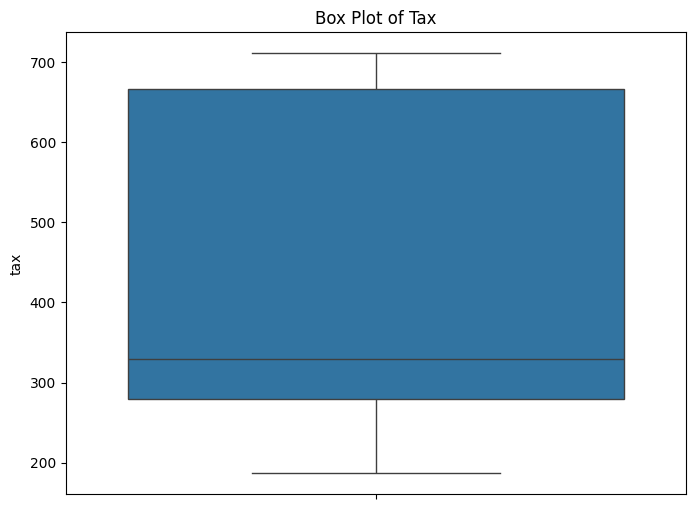

In [22]:
#Box Plot for 'tax'
plt.figure(figsize=(8, 6))
sns.boxplot(y=pdf["tax"])
plt.title("Box Plot of Tax")
plt.show()

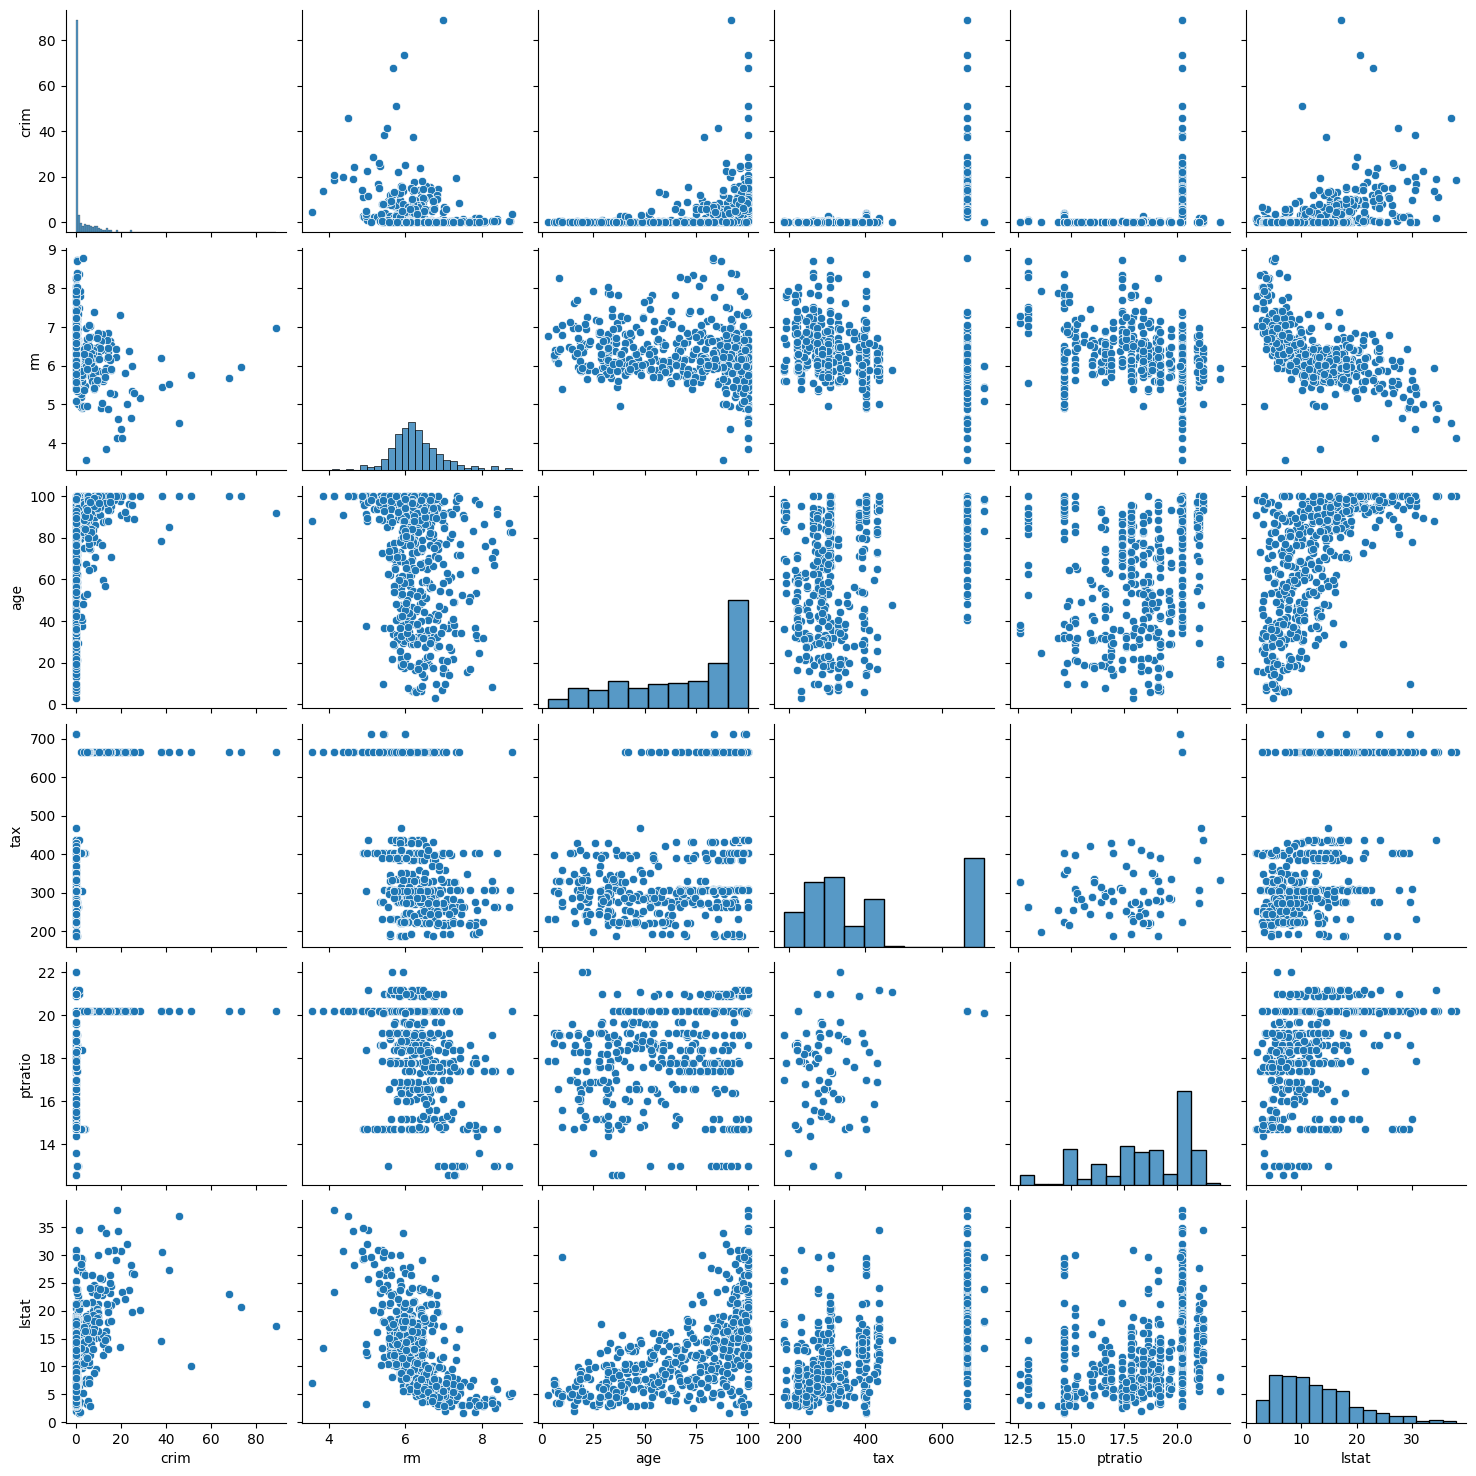

In [23]:
#Pair Plot
sns.pairplot(pdf[['crim', 'rm', 'age', 'tax', 'ptratio', 'lstat']])
plt.show()

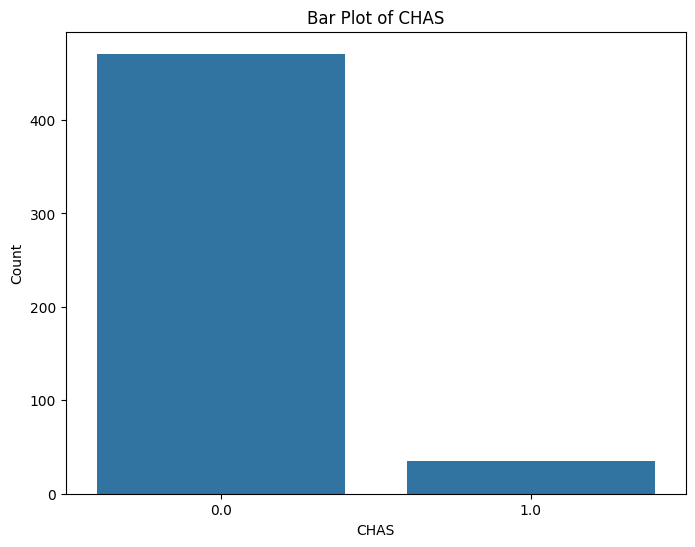

In [24]:
#Bar Plot for 'chas' (assuming 'chas' is a categorical feature)
plt.figure(figsize=(8, 6))
sns.countplot(x='chas', data=pdf)
plt.xlabel("CHAS")
plt.ylabel("Count")
plt.title("Bar Plot of CHAS")
plt.show()

In [12]:
# Get summary statistics of all columns
df.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              crim|                zn|             indus|              chas|                nox|                rm|               age|              dis|              rad|               tax|           ptratio|             lstat|              medv|             Age10|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|               506|               506|               506|               506|                506|               506|               506|              506|              

In [14]:
# Convert relevant columns to numeric types
from pyspark.sql.types import DoubleType
for col in ["crim", "zn", "indus", "chas", "nox", "rm", "age", "dis", "rad", "tax", "ptratio", "lstat"]:
    df = df.withColumn(col, df[col].cast(DoubleType()))

# Continue with vector assembly
assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
df_assembled = assembler.transform(df)
pandas_df = df_assembled.select("features").toPandas()

In [15]:
# Show the last 5 rows of the Pandas DataFrame
pandas_df.tail(5)



,features
501,"[0.06263, 0.0, 11.93, 0.0, 0.573, 6.593, 69.1,..."
502,"[0.04527, 0.0, 11.93, 0.0, 0.573, 6.12, 76.7, ..."
503,"[0.06076, 0.0, 11.93, 0.0, 0.573, 6.976, 91.0,..."
504,"[0.10959, 0.0, 11.93, 0.0, 0.573, 6.794, 89.3,..."
505,"[0.04741, 0.0, 11.93, 0.0, 0.573, 6.03, 80.8, ..."


In [16]:
#Alternatively
# Convert the Pandas DataFrame back to a Spark DataFrame
spark_df = spark.createDataFrame(pandas_df)

# Show the last 5 rows of the Spark DataFrame
spark_df.show(5)

+--------------------+
|            features|
+--------------------+
|[0.00632,18.0,2.3...|
|[0.02731,0.0,7.07...|
|[0.02729,0.0,7.07...|
|[0.03237,0.0,2.18...|
|[0.06905,0.0,2.18...|
+--------------------+
only showing top 5 rows



In [25]:
# Stop the SparkSession
spark.stop()